In [1]:
from google.colab import drive
drive.mount('/content/drive')
print("mounted to drive")

Mounted at /content/drive
mounted to drive


In [2]:
import os
print(os.getcwd())
os.chdir('/content/drive/MyDrive')
print(os.getcwd())

/content
/content/drive/MyDrive


In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [4]:
from tensorflow import keras
model = keras.models.load_model("model_save.h5", custom_objects={'f1_m':f1_m, 'precision_m':precision_m, 'recall_m':recall_m })

In [5]:
import numpy as np
import h5py
import os
import glob
import matplotlib.pyplot as plt
print("successfully imported required libraries")

successfully imported required libraries


In [6]:
import os
print(os.getcwd())
os.chdir('/content/drive/MyDrive/Valid/img')
print(os.getcwd())

/content/drive/MyDrive
/content/drive/MyDrive/Valid/img


In [7]:
def listitems(n):
  validation_url = r'/content/drive/MyDrive/Train/img/image_'+n+'.h5'
  img_val = sorted(glob.glob(validation_url))
  print(img_val)
  VAL_XX = np.zeros((1, 128, 128, 6))
  mask_name = []
  for i, img in enumerate(img_val):
      print(i, img)
      mask_name.append(img.split('/')[-1].replace('image', 'mask'))
      with h5py.File(img) as hdf:
          ls = list(hdf.keys())
          data = np.array(hdf.get('img'))

          # assign 0 for the nan value
          data[np.isnan(data)] = 0.000001

          # to normalize the data 
          mid_rgb = data[:, :, 1:4].max() / 2.0
          mid_slope = data[:, :, 12].max() / 2.0
          mid_elevation = data[:, :, 13].max() / 2.0

          # ndvi calculation
          data_red = data[:, :, 3]
          data_nir = data[:, :, 7]
          data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
          
          # final array
          VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
          VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
          VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
          VAL_XX[i, :, :, 3] = data_ndvi #NDVI
          VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
          VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
  print(VAL_XX.shape)
  return VAL_XX  
  

Enter the number of the file: 161
['/content/drive/MyDrive/Train/img/image_161.h5']
0 /content/drive/MyDrive/Train/img/image_161.h5
(1, 128, 128, 6)
(1, 128, 128, 6)
1/1 [==============================] - 0s 63ms/step


(1, 128, 128, 1)


Text(0.5, 1.0, 'Mask')

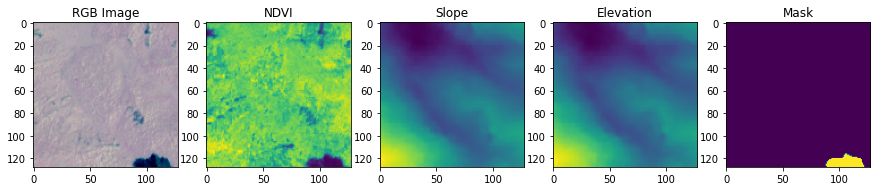

In [12]:
n = input("Enter the number of the file: ")
threshold = 0.5
VAL_XX = listitems(n)
print(VAL_XX.shape)
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
print(pred_img.shape)

fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(1,5,figsize=(15,10))
ax1.imshow(VAL_XX[0, :, :, 0:3])
ax1.set_title("RGB Image")
ax2.imshow(VAL_XX[0, :, :, 3])
ax2.set_title("NDVI")
ax3.imshow(VAL_XX[0, :, :, 4])
ax3.set_title("Slope")
ax4.imshow(VAL_XX[0, :, :, 5])
ax4.set_title("Elevation")
ax5.imshow(pred_img[0, :, :, 0])
ax5.set_title('Mask')